# Restricted Boltzmann Machine: example

## Part relative to the lecture

In [1]:
import numpy as np
from numpy import exp
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import random

#### Read Data

In [5]:
fname = 'dataRBM_q0.1.csv'
# loading data: each row is a list of visible units
data = np.loadtxt(fname, delimiter=',', dtype=int)
# to start, take a small subsample
# v = v[0:10]
N = len(data)
L = len(data[1])
print(f'each of N={N} data has L={L} digits')

each of N=10000 data has L=8 digits


#### Convert data to +1/-1 (spins)

In [6]:
# convert 0,1 -> -1,1 (spin system)
v = 2*data - 1
# store in v0, because later we will shuffle v
v0 = np.zeros_like(v)
v0 = np.copy(v)

for k in range(10):
    print(data[k], v[k])
print('...')

[0 0 1 1 0 0 1 1] [-1 -1  1  1 -1 -1  1  1]
[0 0 1 1 0 0 1 1] [-1 -1  1  1 -1 -1  1  1]
[0 0 1 1 0 1 0 0] [-1 -1  1  1 -1  1 -1 -1]
[1 0 1 1 0 1 1 1] [ 1 -1  1  1 -1  1  1  1]
[0 0 1 1 1 1 0 0] [-1 -1  1  1  1  1 -1 -1]
[0 0 1 1 1 1 0 0] [-1 -1  1  1  1  1 -1 -1]
[1 1 0 0 0 0 1 0] [ 1  1 -1 -1 -1 -1  1 -1]
[1 0 1 1 0 0 1 1] [ 1 -1  1  1 -1 -1  1  1]
[0 1 1 1 0 0 1 1] [-1  1  1  1 -1 -1  1  1]
[1 0 0 0 1 1 0 0] [ 1 -1 -1 -1  1  1 -1 -1]
...


#### Initialize arrays and parameters

In [7]:
#random seed for reproducibility
np.random.seed(12342)
# RBM, nr of hidden units
M = 2
# range of each initial weight
sigma = np.sqrt(4. / float(L+M))
# initial weights (see literature, e.g. page 98, but here not Gaussian)
w = sigma * (2*np.random.rand(L,M)-1)
a = sigma * (2*np.random.rand(L)-1)
b = np.zeros(M)
print(w)
print(a)
print(b)
# store initial weights
w0 = np.copy(w)
a0 = np.copy(a)
b0 = np.copy(b)

[[ 0.2312481  -0.1921846 ]
 [ 0.41981402 -0.35446294]
 [-0.08209399 -0.16087596]
 [-0.39923633 -0.55184291]
 [ 0.21317147 -0.16707938]
 [ 0.59531317 -0.01861671]
 [-0.02474645  0.03761957]
 [ 0.54715523  0.56265455]]
[-0.55847423 -0.61468609 -0.31559158  0.59231902 -0.46253863 -0.08086142
  0.20653201 -0.1123049 ]
[0. 0.]


## Functions

#### Functions for Plotting

[0, 0, 0, 0, 0, 0, 0, 0]
[1, 1]


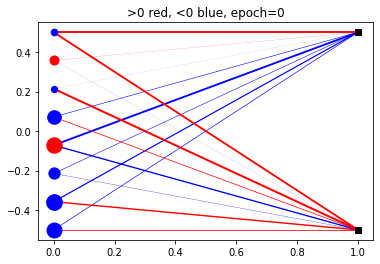

In [8]:
# line-up layers vertically
def create_coord(n_points, x0):
    x = [x0] * n_points
    print(x)
    y = list(range(n_points))
    for i in range(n_points):
        y[i] = y[i]/(n_points-1.) - 0.5
    return (x,y)

(x1,y1) = create_coord(L,0)
(x2,y2) = create_coord(M,1)

# choose color according to sign
def mycolor(val):
    if val>0:
        return 'red'
    elif val<0:
        return 'blue'
    else:
        return 'black'

def plotgraph(w, a, b, epoch=0):
    # zorder --> scatter plot of dots on top of lines
    # A: make max line width = 2
    A = 2./w.max()
    for i in range(L):#visible units
        for j in range(M): #hidden units
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*np.abs(w[i][j]))
    
    # PS: scale of the point size
    PS = 400
    PSmin = 40
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=max(PSmin, PS*np.abs(a[i])), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        plt.scatter(x2[j], y2[j], s=max(PSmin, PS*np.abs(b[j])), zorder=2, c=mycolor(b[j]), marker='s')
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()

plotgraph(w,a,b)

#### Sigmoid Function

In [9]:
# eq(213) page 97
# activation via sigmoid
#this applies also for the backpro
def activate(v_in,wei,bias,info=False):
    act = np.dot(v_in, wei) + bias
    prob = 1. / (1. + exp(-act)) #sigmoid
    n = np.shape(act)
    # a list on -1's
    v_out = -np.ones(n, dtype=int)
    # activate the 1's with probability prob
    v_out[np.random.random_sample(n) < prob] = 1
    if info:
        print('input=', v_in)
        print('act=', act)
        print('prob=', prob)
        print('output=', v_out)
    return v_out

k = 0
activate(v0[k], w, b, info=True)

input= [-1 -1  1  1 -1 -1  1  1]
act= [-1.4184683   0.61989888]
prob= [0.19490182 0.65019555]
output= [-1  1]


array([-1,  1])

#### RBM Train

We have chosen to put together in a function such that we can easily handle the parameters.

In [10]:
def boltzmann(v,w,a,b,l_rate=1.0, mini=500, max_epoch=20, M=2, plotting=False):
    if plotting:
        plotgraph(w,a,b,0)  
    m = 0
    # train model
    for epoch in range(1,1+max_epoch):
        l_rate_m = l_rate/mini
        for k in range(N):
            if m==0:
                #initialize averages in miniblock
                v_data, v_model = np.zeros(L), np.zeros(L)
                h_data, h_model = np.zeros(M), np.zeros(M)
                vh_data, vh_model = np.zeros((L,M)), np.zeros((L,M))

            # activations
            h  = activate(v[k],w,b)
            vf = activate(h, w.T, a)
            hf = activate(vf, w, b)

            # for the average
            v_data += v[k]
            v_model += vf
            h_data += h
            h_model += hf
            vh_data += np.outer(v[k].T, h)
            vh_model += np.outer(vf.T, hf)

            m += 1
            # minibatch
            if m==mini:
                # gradient of the likelihood: follow it along its positive direction
                # vanilla gradient descent method
                dw = l_rate_m*(vh_data - vh_model)
                da = l_rate_m*(v_data - v_model)
                db = l_rate_m*(h_data - h_model)
                if epoch<=2 and k <=mini:
                    print('---------- epoch =',epoch,' k=',k,' M=',m)
                    print('dw =',dw)
                    print('da =',da)
                    print('db =',db)
                #basic step of vanilla gradient descent, from eq.(211)
                w += dw
                a += da
                b += db
                m = 0

        print('completed epoch',epoch,'with l_rate = ',l_rate)

        #randomize the order of the input data   #minibatches differents in every epoch
        np.random.shuffle(v) 
        
        # let the learning rate decay as epoch^-1
        l_rate = l_rate / (0.2*l_rate+1)
        
        if plotting:
            plotgraph(w,a,b,epoch)

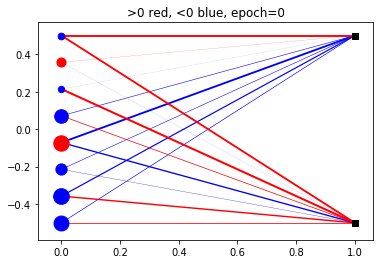

---------- epoch = 1  k= 499  M= 500
dw = [[ 0.296  0.132]
 [ 0.148  0.168]
 [-0.316  0.008]
 [-0.16   0.156]
 [-0.108 -0.208]
 [-0.064 -0.268]
 [ 0.016  0.188]
 [-0.244  0.048]]
da = [ 0.192  0.244  0.164 -0.304  0.284 -0.024 -0.152  0.076]
db = [ 0.16  -0.036]
completed epoch 1 with l_rate =  1.0


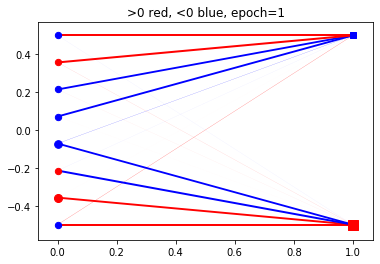

---------- epoch = 2  k= 499  M= 500
dw = [[-0.03666667 -0.06666667]
 [-0.00333333  0.01333333]
 [-0.01333333 -0.01666667]
 [-0.04        0.09      ]
 [ 0.          0.00333333]
 [ 0.01333333 -0.00333333]
 [ 0.02333333  0.02      ]
 [-0.05333333  0.03      ]]
da = [-0.05333333 -0.07333333  0.03        0.01666667  0.02333333  0.03666667
  0.00666667  0.01666667]
db = [-0.02333333  0.00666667]
completed epoch 2 with l_rate =  0.8333333333333334


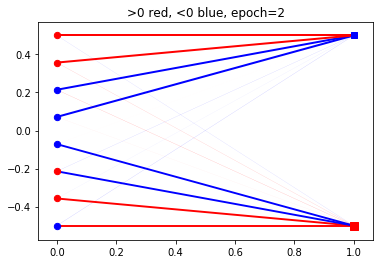

completed epoch 3 with l_rate =  0.7142857142857143


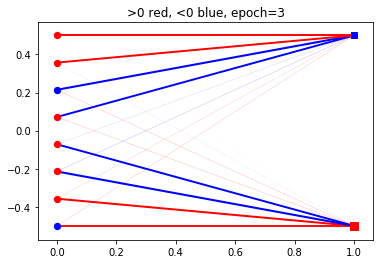

completed epoch 4 with l_rate =  0.625


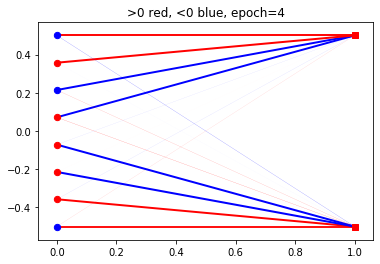

completed epoch 5 with l_rate =  0.5555555555555556


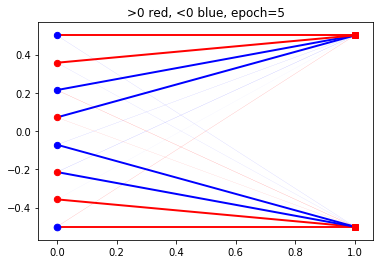

completed epoch 6 with l_rate =  0.5


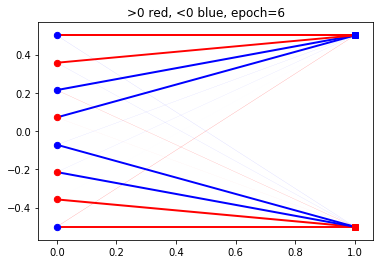

completed epoch 7 with l_rate =  0.45454545454545453


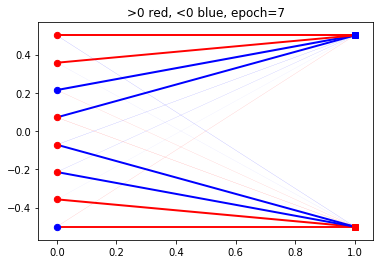

completed epoch 8 with l_rate =  0.4166666666666667


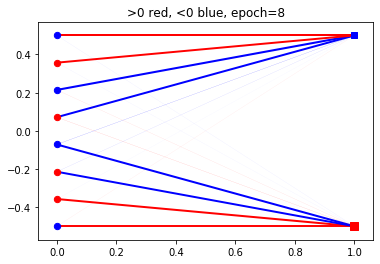

completed epoch 9 with l_rate =  0.38461538461538464


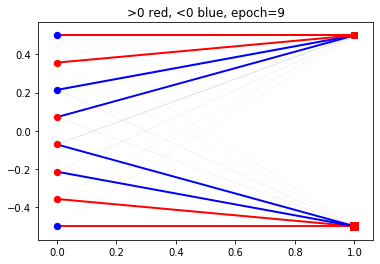

completed epoch 10 with l_rate =  0.3571428571428572


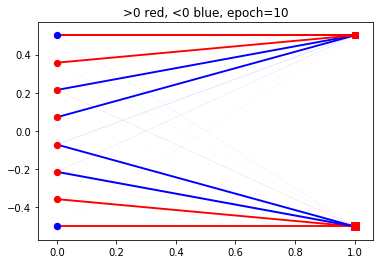

completed epoch 11 with l_rate =  0.3333333333333334


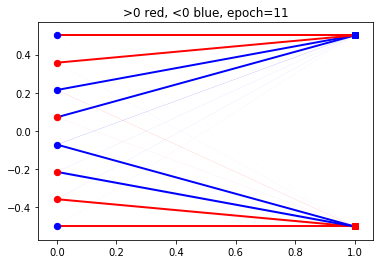

completed epoch 12 with l_rate =  0.3125000000000001


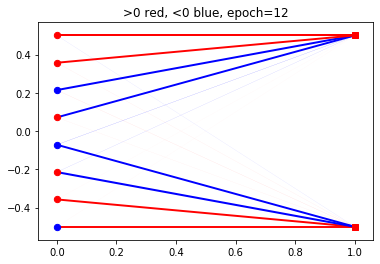

completed epoch 13 with l_rate =  0.29411764705882365


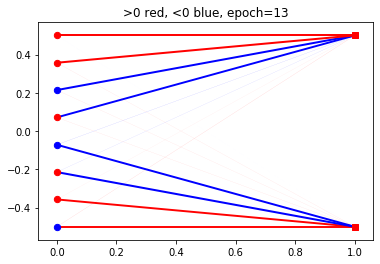

completed epoch 14 with l_rate =  0.2777777777777779


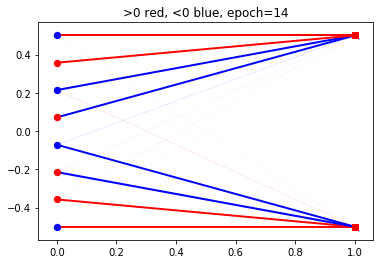

completed epoch 15 with l_rate =  0.2631578947368422


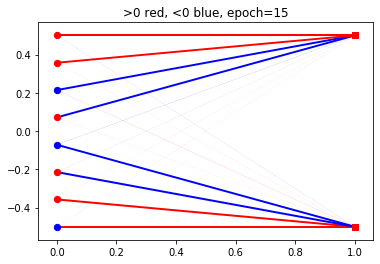

completed epoch 16 with l_rate =  0.2500000000000001


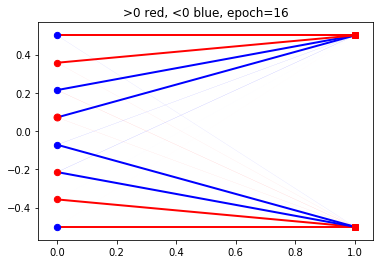

completed epoch 17 with l_rate =  0.2380952380952382


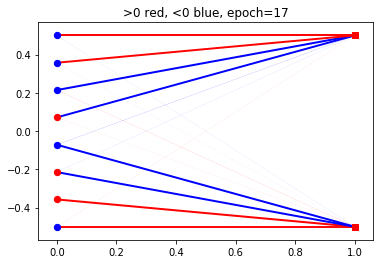

completed epoch 18 with l_rate =  0.22727272727272735


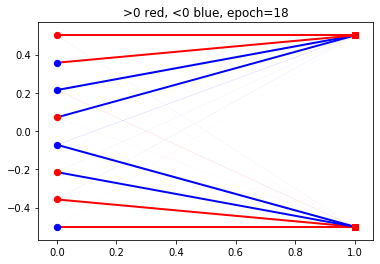

completed epoch 19 with l_rate =  0.21739130434782616


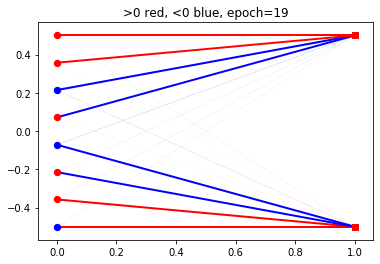

completed epoch 20 with l_rate =  0.20833333333333343


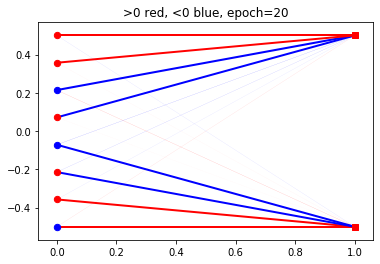

In [8]:
boltzmann(v,w,a,b,plotting=True)

Clearly inmediatly the network converges to something meaninful. The second two bits and the third one share the same unit. Bits 0 and 1 are the same quantities. Red is positive.  The hidden unit may be able to recongnize. By two hidden units the network converges to something. let's see if this is true....

In [9]:
print('w0=',w0)
print('w=',w)
print('a0=',a0)
print('a=',a)
print('b0=',b0)
print('b=',b)

w0= [[ 0.2312481  -0.1921846 ]
 [ 0.41981402 -0.35446294]
 [-0.08209399 -0.16087596]
 [-0.39923633 -0.55184291]
 [ 0.21317147 -0.16707938]
 [ 0.59531317 -0.01861671]
 [-0.02474645  0.03761957]
 [ 0.54715523  0.56265455]]
w= [[ 2.17926075  0.04685452]
 [ 2.19376516 -0.03396572]
 [-2.19323479 -0.06757545]
 [-2.2127436  -0.09030472]
 [ 0.01158843 -2.19945248]
 [ 0.08487786 -2.23730153]
 [ 0.01449727  2.17693805]
 [-0.04131345  2.19300581]]
a0= [-0.55847423 -0.61468609 -0.31559158  0.59231902 -0.46253863 -0.08086142
  0.20653201 -0.1123049 ]
a= [-0.10227707  0.01722918  0.04698073 -0.04670707  0.03345603 -0.00059673
  0.01994835  0.02138319]
b0= [0. 0.]
b= [0.06390323 0.02545633]


### Denoising (?)

In [10]:
# original, non-reshuffled data in v0
mini=500
v1 = np.zeros_like(v0)

for k in range(N):
    # positive CD phase: generating h
    h = activate(v0[k],w,b)
    #negative CD phase: generating fantasy vf
    v1[k] = activate(h,w.T,a)
# difference between fantasy and data
diff = (v1 - v0)/2
str0 = 'M'+str(M)+'-mini'+str(mini)+fname
np.savetxt('fant-'+str0, (v1+1)/2, fmt='%d', delimiter=',')
np.savetxt('diff-'+str0, diff, fmt='%d', delimiter=',')

Z = int(L/4)
vv0 = [0]*Z
vv1 = [1]*Z
case = (vv1 + vv0 + vv1 + vv0,
        vv0 + vv1 + vv1 + vv0,
        vv1 + vv0 + vv0 + vv1,
        vv0 + vv1 + vv0 + vv1)

for k in range(10):
    vec0 = ((v0[k]+1)/2).astype(int)
    vec1 = ((v1[k]+1)/2).astype(int)
    is0 = (vec1==case[0]).all()
    is1 = (vec1==case[1]).all()
    is2 = (vec1==case[2]).all()
    is3 = (vec1==case[3]).all()
    print(vec0, vec1, (is0 or is1 or is2 or is3))
print('...')

[0 0 1 1 0 0 1 1] [0 0 1 1 0 0 1 0] False
[0 0 1 1 0 0 1 1] [1 0 1 1 0 0 1 1] False
[0 0 1 1 0 1 0 0] [0 1 1 1 1 0 0 0] False
[1 0 1 1 0 1 1 1] [0 0 1 1 0 0 1 1] True
[0 0 1 1 1 1 0 0] [0 0 0 1 0 1 0 0] False
[0 0 1 1 1 1 0 0] [0 0 1 1 1 1 0 0] True
[1 1 0 0 0 0 1 0] [1 0 0 0 0 0 1 1] False
[1 0 1 1 0 0 1 1] [0 0 1 1 0 0 1 0] False
[0 1 1 1 0 0 1 1] [0 0 1 1 0 0 1 1] True
[1 0 0 0 1 1 0 0] [1 1 0 0 1 0 0 0] False
...


In [11]:
# Fraction of correct sequences generated
counter = 0
for k in range(N):
    vec0 = ((v0[k]+1)/2).astype(int)
    vec1 = ((v1[k]+1)/2).astype(int)
    is0 = (vec1==case[0]).all()
    is1 = (vec1==case[1]).all()
    is2 = (vec1==case[2]).all()
    is3 = (vec1==case[3]).all()
    if (is0 or is1 or is2 or is3): 
        counter+=1

print('Percentage of correct sequences generated = ', counter/N*100, '%')

Percentage of correct sequences generated =  42.38 %


Most of the time it doesnt work. An attempt is made by lowering the temperature.

## Part 1

#### New sigmoid function and reconstruction function

In [11]:
"""
Let's create a sigmoid function dependent on the temperature.
"""

def activate_temp(v_in,wei,bias, T,info=False):
    act = np.dot(v_in, wei) + bias
    #### Takes care of possible overflows
    act[(act/T)<-50] = -50*T
    prob = 1. / (1. + exp(-act/T))
    n = np.shape(act)
    # a list on -1's
    v_out = -np.ones(n, dtype=int)
    # activate the 1's with probability prob
    v_out[np.random.random_sample(n) < prob] = 1
    if info:
        print('input=', v_in)
        print('act=', act)
        print('prob=', prob)
        print('output=', v_out)
    return v_out

In [12]:
"""
This two functions provide the most sensible reconstruction of the data
"""

def reconstruct_piece(piece):
    piece_1 = piece[:2]
    piece_2 = piece[2:]
    if piece_1[0]==piece_1[1]:
        piece_2 = -piece_1
    elif piece_2[0]==piece_2[1]:
        piece_1 = -piece_2
    else:
        piece_1 = np.asarray([1,1])
        piece_2 = -piece_1
    return np.append(piece_1, piece_2)

def correct_reconstruction(x):
    x_first = x[:4]
    x_second = x[4:]
    x_first_r = reconstruct_piece(x_first)
    x_second_r = reconstruct_piece(x_second)
    return np.append(x_first_r, x_second_r)

In [15]:
"""
Reconstruction in the general (Z=!2) case
"""

def gen_reconstruct_piece(piece):
    lenpi = int(len(piece))
    halflenpi = int(lenpi/2)
    quarlenpi = halflenpi/2
    
    piece_1 = piece[:halflenpi]
    piece_2 = piece[halflenpi:]
    if sum(piece_1)==0 and sum(piece_2)==0:
        choice = random.randint(0,1)*2 - 1
        piece_1 = [choice]*halflenpi
        piece_2 = [-choice]*halflenpi
    elif sum(piece_1)>=0 and sum(piece_2)<=0:    #(but the case where both are 0 is before)
        piece_1 = [1]*halflenpi
        piece_2 = [-1]*halflenpi
    elif sum(piece_1)<=0 and sum(piece_2)>=0:
        piece_1 = [-1]*halflenpi
        piece_2 = [1]*halflenpi
    else:
        choice = random.randint(0,1)*2 - 1
        piece_1 = [choice]*halflenpi
        piece_2 = [-choice]*halflenpi
    return np.append(piece_1, piece_2)

def gen_correct_reconstruction(x, L):
    x_first = x[:int(L/2)]
    x_second = x[int(L/2):]
    x_first_r = gen_reconstruct_piece(x_first)
    x_second_r = gen_reconstruct_piece(x_second)
    return np.append(x_first_r, x_second_r)    

### Training

In [14]:
def result_checking(v0,w,a,b,temp,Z,N=10000):
    L = int(Z*4)
    v1 = np.zeros_like(v0) #fantasy particles
    for k in range(N): 
        h = activate_temp(v0[k],w,b, temp)
        v1[k] = activate_temp(h,w.T,a, temp)

    # difference between fantasy and data
    diff = (v1 - v0)/2
    vv0 = [0]*Z
    vv1 = [1]*Z
    case = (vv1 + vv0 + vv1 + vv0,
            vv0 + vv1 + vv1 + vv0,
            vv1 + vv0 + vv0 + vv1,
            vv0 + vv1 + vv0 + vv1)
    count = 0
    count_correct = 0

    for k in range(N):
        vec0 = ((v0[k]+1)/2).astype(int)
        vec1 = ((v1[k]+1)/2).astype(int)
        vec_r = ((gen_correct_reconstruction(v0[k],L)+1)/2).astype(int)  #back from -1/1 to 0/1 AFTER reconstruction
        is0 = (vec1==case[0]).all()
        is1 = (vec1==case[1]).all()
        is2 = (vec1==case[2]).all()
        is3 = (vec1==case[3]).all()

        if (vec1==vec_r).all():
            count_correct += 1
        if ((is0 or is1 or is2 or is3)==True):
            count += 1
    
    return count, count_correct

In [16]:
"""
This function is almost analogue than the one used at the beginning of the notebook. The 
difference is that here we use a personalized learning rate.
"""

def temp_boltzmann(v,w,a,b,temp,Z, mini=500, max_epoch=40, M=2,
                  l_rate_init=1, l_rate_fin = 0.001):
    
    v0 = np.copy(v)    
    m = 0
    l_rate = l_rate_init
    L = int(Z*4)
    
    log_true_values = []
    log_correct_reconstructions = []
    
    # train model
    for epoch in range(1,1+max_epoch):
        l_rate_m = l_rate/mini*temp**2
        for k in range(N):
            if m==0:
                #initialize averages in miniblock
                v_data, v_model = np.zeros(L), np.zeros(L)
                h_data, h_model = np.zeros(M), np.zeros(M)
                vh_data, vh_model = np.zeros((L,M)), np.zeros((L,M))

            # activations
            h = activate_temp(v[k],w,b, temp)
            vf = activate_temp(h, w.T, a, temp)
            hf = activate_temp(vf, w, b, temp)

            # for the average
            v_data   += v[k]
            v_model  += vf
            h_data   += h
            h_model  += hf
            vh_data  += np.outer(v[k].T, h)
            vh_model += np.outer(vf.T, hf)

            m += 1
            # minibatch
            if m==mini:
                # gradient of the likelihood: follow it along its positive direction
                # vanilla gradient descent method
                dw = l_rate_m*(vh_data - vh_model)
                da = l_rate_m*(v_data - v_model)
                db = l_rate_m*(h_data - h_model)
            
                #basic step of vanilla gradient descent, from eq.(211)
                w += dw
                a += da
                b += db
                m = 0

        #print('completed epoch',epoch,'with l_rate = ',l_rate)  verbose

        #randomize the order of the input data such thta minibatches will be differents in every epoch
        np.random.shuffle(v) 
        
        # let the learning rate decay as epoch^-1
        l_rate -= (l_rate_init - l_rate_fin)/max_epoch
        
        # call result checking function
        count, count_correct = result_checking(v0,w,a,b,temp,Z,N=10000)
        
        log_true_values.append(count)
        log_correct_reconstructions.append(count_correct)
        
    return log_true_values,  log_correct_reconstructions

In [17]:
# Let's try with more temperature values

TT = [0.01, 0.1, 0.2, 0.5, 1]

#temp_boltzmann
logs_true_values = []
logs_correct_reconstructions = []

for temp in TT:
    w = sigma * (2*np.random.rand(L,M)-1)
    a = sigma * (2*np.random.rand(L)-1)
    b = np.zeros(M)
    print('Temperature:', temp)
    
    ltv, lcr = temp_boltzmann(v0,w,a,b,temp,Z=2, mini=500, max_epoch=20, M=2,l_rate_init=1, l_rate_fin = 0.001)
    logs_true_values.append(ltv)
    logs_correct_reconstructions.append(lcr)
    
    print('...')

Temperature: 0.01
...
Temperature: 0.1
...
Temperature: 0.2
...
Temperature: 0.5
...
Temperature: 1
...


What we did here, is essentially trying to reconstruct the correct sequence from the original data v0 (trough the function gen_correct_reconstruction()), to solve the bitflip problem, and comparing them to the fantasy data generated after the training phase.

## Part 2

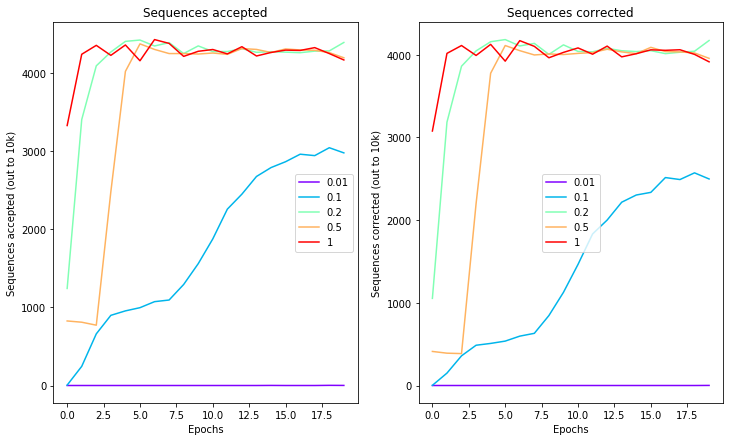

In [18]:
colors = plt.cm.rainbow(np.linspace(0,1,len(logs_correct_reconstructions)))
fig, axs = plt.subplots(1,2,figsize=(12,7))
for i in range(len(logs_correct_reconstructions)):
    axs[0].plot(logs_true_values[i], color=colors[i], label=str(TT[i]))
    axs[1].plot(logs_correct_reconstructions[i], color=colors[i], label=str(TT[i]))
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Sequences accepted (out to 10k)")
    axs[1].set_ylabel("Sequences corrected (out to 10k)")
    axs[0].set_title("Sequences accepted")
    axs[1].set_title("Sequences corrected")
    axs[0].legend()
    axs[1].legend()

Sequences accepted = fantasy sequences generated by the model, that are acceptable, in the sense that we can easily associate a label to them. <br>
Sequences corrected = sequences accepted + correct label respect to original data.

With temperature 0.1 we achieve the best result. While with Temperature too big this is awful

Storing the best temperature

In [19]:
T_BEST = 0.1

## Part 3

In [3]:
random.seed(12345)

def data_generation(cases=4, block_size=2, addfifth=False, addsixth=False, q=0.1):
    N = 10000
    # possible different cases
    C = cases
    # block size
    Z = block_size
    # size of each data point
    L = C*Z

    
    y = [0]*N
    x = [[0]*L for j in range(N)]
    v0 = [0]*Z
    v1 = [1]*Z
    v2 = [1]+[0]*(Z-1)
    
    case = [v1 + v0 + v1 + v0,
            v0 + v1 + v1 + v0,
            v1 + v0 + v0 + v1,
            v0 + v1 + v0 + v1]
    
    if addfifth: 
        case += [v1 + v1 + v1 + v1];
        C += 1
    
    if addsixth:
        case += [v2 + v2 + v2 + v0];
        C += 1
                        
    for i in range(N):
        y[i] = random.randint(0,C-1)
        x[i][:] = case[y[i]]
        for j in range(L):
            if random.random()<q:
                x[i][j] = 1-x[i][j]
            
    #print('________________DATA')
    #for i in range(10):
    #    print('"', y[i], '" ', *x[i], sep="")
    #print('...')
    return np.array(x)

### 5 Cases

In [21]:
v_5_states = data_generation(addfifth=True)
v_5_states = v_5_states*2 - 1
v_5_states[:10]

array([[-1, -1,  1,  1, -1, -1,  1,  1],
       [-1, -1,  1,  1, -1, -1,  1,  1],
       [ 1,  1,  1,  1,  1, -1,  1,  1],
       [ 1, -1,  1,  1, -1,  1,  1,  1],
       [ 1,  1,  1,  1,  1,  1, -1,  1],
       [-1, -1,  1,  1, -1, -1,  1, -1],
       [-1, -1, -1,  1,  1,  1, -1,  1],
       [ 1, -1, -1, -1,  1,  1, -1, -1],
       [ 1, -1, -1, -1,  1,  1, -1, -1],
       [ 1, -1, -1, -1,  1,  1, -1, -1]])

In [22]:
# more hidden neurons
L = 8
temp = T_BEST
v = v_5_states
hidden_neurons = [2,4,6,8,10] # number of hidden neurons

logs_true_values = []
logs_correct_reconstructions = []


for M in hidden_neurons:
    print('M=',M)
    print('Temperature:', temp)
    
    w = sigma * (2*np.random.rand(L,M)-1)
    a = sigma * (2*np.random.rand(L)-1)
    b = np.zeros(M)

    ltv, lcr= temp_boltzmann(v,w,a,b,temp,Z=2, mini=500, max_epoch=20, M=M,
                                    l_rate_init=1, l_rate_fin = 0.001)
    logs_true_values.append(ltv)
    logs_correct_reconstructions.append(lcr)
    
    print('...')

M= 2
Temperature: 0.1
...
M= 4
Temperature: 0.1
...
M= 6
Temperature: 0.1
...
M= 8
Temperature: 0.1
...
M= 10
Temperature: 0.1
...


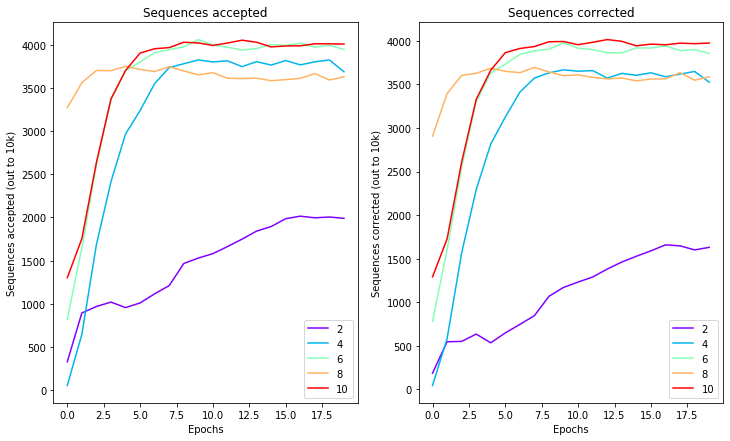

In [23]:
colors = plt.cm.rainbow(np.linspace(0,1,len(logs_correct_reconstructions)))
fig, axs = plt.subplots(1,2,figsize=(12,7))

for i in range(len(logs_correct_reconstructions)):
    axs[0].plot(logs_true_values[i], color=colors[i], label=str(hidden_neurons[i]))
    axs[1].plot(logs_correct_reconstructions[i], color=colors[i], label=str(hidden_neurons[i]))
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Sequences accepted (out to 10k)")
    axs[1].set_ylabel("Sequences corrected (out to 10k)")
    axs[0].set_title("Sequences accepted")
    axs[1].set_title("Sequences corrected")
    axs[0].legend()
    axs[1].legend()

The best number of hidden neurons adding the fifth case seems to be 10

### 6 Cases

In [24]:
v_6_states = data_generation(addfifth=True, addsixth=True)
v_6_states = v_6_states*2 - 1
v_6_states[:10]

array([[-1, -1,  1,  1, -1, -1,  1,  1],
       [ 1,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  1, -1, -1,  1,  1, -1, -1],
       [ 1,  1, -1, -1,  1,  1, -1, -1],
       [ 1,  1, -1, -1, -1, -1,  1,  1],
       [ 1,  1,  1,  1,  1,  1,  1, -1],
       [ 1, -1,  1, -1,  1, -1, -1, -1],
       [ 1,  1,  1,  1,  1,  1,  1,  1],
       [ 1, -1,  1, -1,  1, -1,  1, -1],
       [-1, -1, -1,  1,  1,  1, -1, -1]])

In [25]:
# more hidden neurons
L = 8
temp = T_BEST
v = v_6_states
hidden_neurons = [10,20,30,40,50] # number of hidden neurons

logs_true_values = []
logs_correct_reconstructions = []

for M in hidden_neurons:
    print('M=',M)
    w = sigma * (2*np.random.rand(L,M)-1)
    a = sigma * (2*np.random.rand(L)-1)
    b = np.zeros(M)
    print('Temperature:', temp)
    
    ltv, lcr = temp_boltzmann(v,w,a,b,temp,Z=2, mini=500, max_epoch=20, M=M,l_rate_init=1, l_rate_fin = 0.001)
        
    logs_true_values.append(ltv)
    logs_correct_reconstructions.append(lcr)
    
    print('...')

M= 10
Temperature: 0.1
...
M= 20
Temperature: 0.1
...
M= 30
Temperature: 0.1
...
M= 40
Temperature: 0.1
...
M= 50
Temperature: 0.1
...


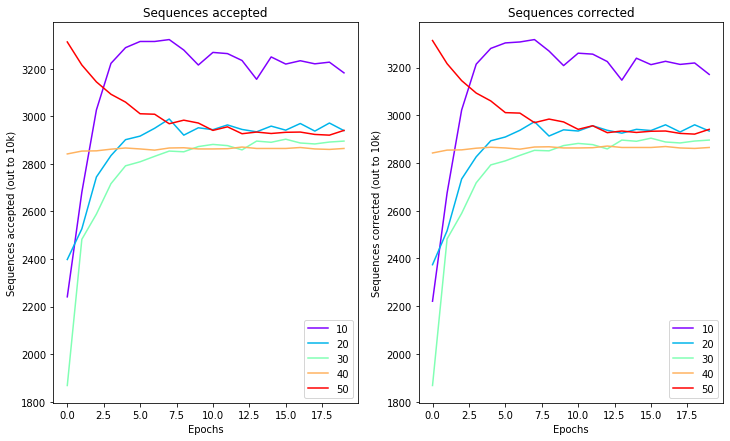

In [26]:
colors = plt.cm.rainbow(np.linspace(0,1,len(logs_correct_reconstructions)))
fig, axs = plt.subplots(1,2,figsize=(12,7))

for i in range(len(logs_correct_reconstructions)):
    axs[0].plot(logs_true_values[i], color=colors[i], label=str(hidden_neurons[i]))
    axs[1].plot(logs_correct_reconstructions[i], color=colors[i], label=str(hidden_neurons[i]))
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Sequences accepted (out to 10k)")
    axs[1].set_ylabel("Sequences corrected (out to 10k)")
    axs[0].set_title("Sequences accepted")
    axs[1].set_title("Sequences corrected")
    axs[0].legend()
    axs[1].legend()

When we add the 6th case as well, being far more complicated than the others, since it doesn't couple the input neurons, we need a order of 10 hidden neurons in order for the RBM to work properly.

## Part 4

In [19]:
q_list = [0.3, 0.5, 0.1]
Z_list = [2,4,4]
data_list = [0]*len(q_list)
orig_data_list = data_list

for ii in range(len(data_list)):
    data_list[ii] = data_generation(cases=4, block_size=Z_list[ii], addfifth=False, addsixth=False, 
                                    q=q_list[ii])
    data_list[ii] = 2*data_list[ii] - 1
    orig_data_list = data_list

In [20]:
T_BEST = 0.1
logs_true_valuesbis = []
logs_correct_reconstructionsbis = []
temp = T_BEST

for ii in range(len(data_list)):
    
    print('q=',q_list[ii],'  Z=',Z_list[ii])
    M=2
    L = 4*Z_list[ii]
    w = sigma * (2*np.random.rand(L,M)-1)
    a = sigma * (2*np.random.rand(L)-1)
    b = np.zeros(M)
    print('Temperature:', temp)

    ltv, lcr = temp_boltzmann(data_list[ii],w,a,b,temp,Z=Z_list[ii], mini=500, max_epoch=20, M=2,
                              l_rate_init=1, l_rate_fin = 0.001)
        
    logs_true_valuesbis.append(ltv)
    logs_correct_reconstructionsbis.append(lcr)
    
    print('...')

q= 0.3   Z= 2
Temperature: 0.1
...
q= 0.5   Z= 4
Temperature: 0.1
...
q= 0.1   Z= 4
Temperature: 0.1
...


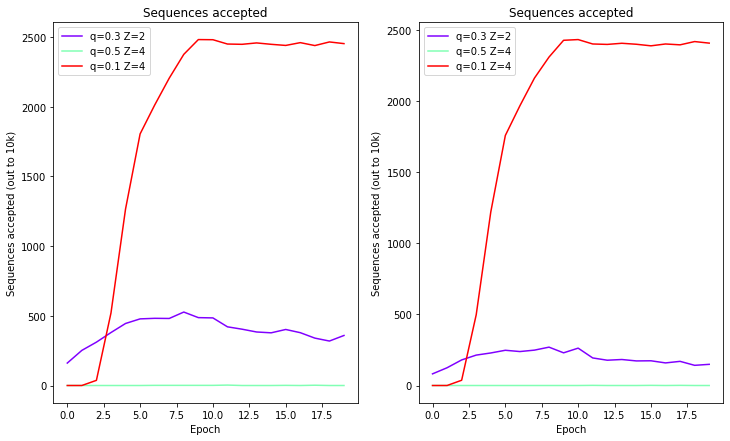

In [25]:
colors = plt.cm.rainbow(np.linspace(0,1,len(logs_correct_reconstructionsbis)))
fig, axs = plt.subplots(1,2,figsize=(12,7))
ax0 = axs[0]
ax1 = axs[1]
for i in range(len(logs_correct_reconstructionsbis)):
    lab = 'q='+str(q_list[i])+' Z='+str(Z_list[i])
    ax0.plot(logs_true_valuesbis[i], color=colors[i], label=lab)
    ax0.set_xlabel('Epoch')
    ax0.set_ylabel('Sequences accepted (out to 10k)')
    ax0.set_title('Sequences accepted')
    ax1.plot(logs_correct_reconstructionsbis[i], color=colors[i], label=lab)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Sequences accepted (out to 10k)')
    ax1.set_title('Sequences accepted')
    ax0.legend()
    ax1.legend()